In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import cv2
from tqdm import tqdm

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

# Check if bf16 is supported
if not torch.cuda.is_bf16_supported():
    print("bfloat16 is not supported on this GPU")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 generic predictor

In [6]:
from sam2.build_sam import build_sam2_generic_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

predictor = build_sam2_generic_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
def show_mask(mask: np.ndarray | torch.Tensor, ax: plt.Axes, obj_id=None, random_color=False):
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape((h, w, 1)) * color.reshape((1, 1, -1))
    ax.imshow(mask_image)


def show_points(coords: np.ndarray, labels: np.ndarray, ax: plt.Axes, marker_size=200):
    if isinstance(coords, torch.Tensor):
        coords = coords.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

### Select an example video

In [8]:
cap = cv2.VideoCapture("./videos/bedroom.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
orig_hw = (height, width)

def read_frame(cap) -> torch.Tensor:
    ret, frame = cap.read()
    if not ret:
        return None
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = torch.as_tensor(frame).permute(2, 0, 1).to(device)
    frame = frame / 255.0
    return frame

In [9]:
from sam2.modeling.sam2_prompt import SAM2Prompt


points_coords_obj0 = torch.tensor([400.0, 150.0], device=device).reshape((1, 1, 2))

points_labels_obj0 = torch.tensor([1], device=device).reshape((1, 1))

points_coords_obj1 = torch.tensor(
    [[204.0, 278.0], [258.0, 172.0]], device=device
).reshape((1, 2, 2))
points_labels_obj1 = torch.tensor([[1], [0]], device=device).reshape((1, 2))

prompt_obj0 = SAM2Prompt(
    obj_id=0,
    orig_img_size_hw=orig_hw,
    points_coords=points_coords_obj0,
    points_labels=points_labels_obj0,
)
prompt_obj1 = SAM2Prompt(
    obj_id=1,
    orig_img_size_hw=orig_hw,
    points_coords=points_coords_obj1,
    points_labels=points_labels_obj1,
)

initial_frame = read_frame(cap)

results = predictor.forward(
    frame=initial_frame, frame_idx=0, prompts=[prompt_obj0, prompt_obj1]
)

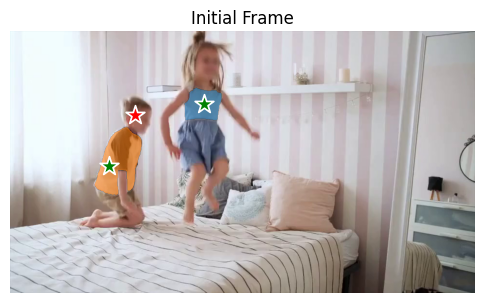

In [10]:
plt.figure(figsize=(6, 4))
plt.title("Initial Frame")
plt.axis("off")
plt.imshow(initial_frame.permute(1, 2, 0).cpu().numpy())
show_mask((results[0].best_mask_logits > 0), plt.gca(), obj_id=0)
show_mask((results[1].best_mask_logits > 0), plt.gca(), obj_id=1)
show_points(points_coords_obj0, points_labels_obj0, plt.gca())
show_points(points_coords_obj1, points_labels_obj1, plt.gca())
plt.show()

### Propagate in video

Propagating in video:  10%|▉         | 19/199 [00:09<01:26,  2.09it/s, stored_cond_mem=2, stored_non_cond_mem=40]

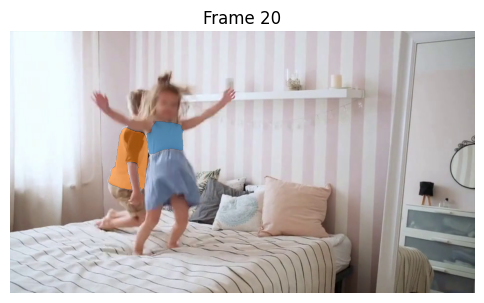

Propagating in video:  20%|█▉        | 39/199 [00:19<01:16,  2.09it/s, stored_cond_mem=2, stored_non_cond_mem=80]

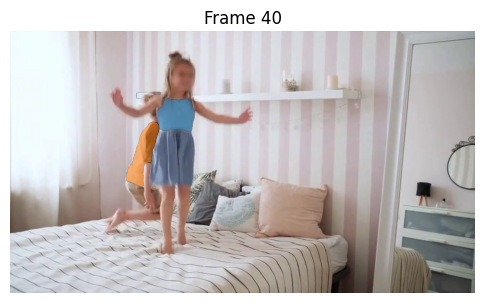

Propagating in video:  30%|██▉       | 59/199 [00:29<01:09,  2.01it/s, stored_cond_mem=2, stored_non_cond_mem=120]

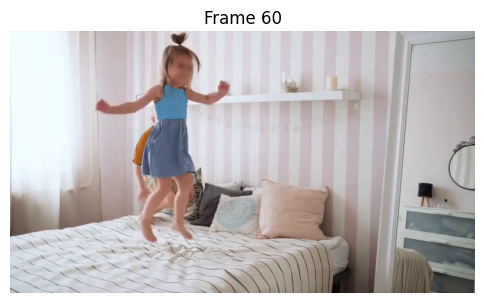

Propagating in video:  40%|███▉      | 79/199 [00:39<00:57,  2.08it/s, stored_cond_mem=2, stored_non_cond_mem=160]

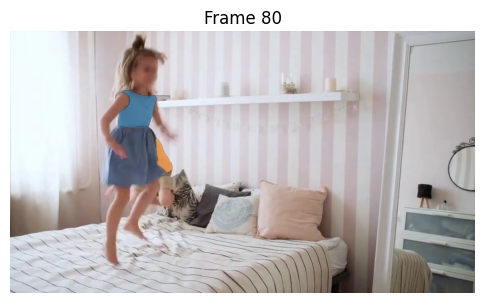

Propagating in video:  50%|████▉     | 99/199 [00:49<00:48,  2.08it/s, stored_cond_mem=2, stored_non_cond_mem=200]

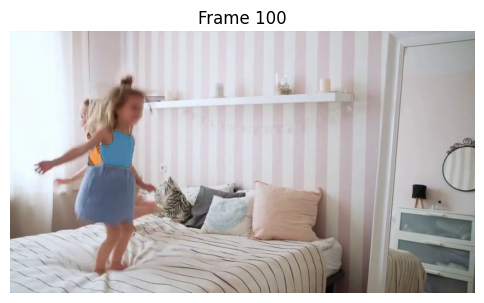

Propagating in video:  60%|█████▉    | 119/199 [00:59<00:38,  2.08it/s, stored_cond_mem=2, stored_non_cond_mem=240]

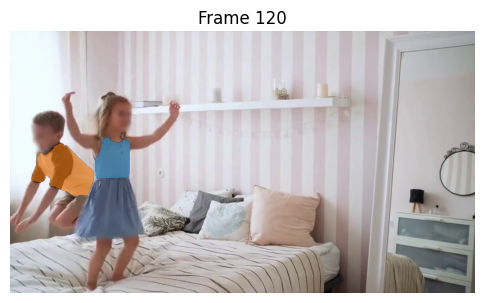

Propagating in video:  70%|██████▉   | 139/199 [01:08<00:28,  2.09it/s, stored_cond_mem=2, stored_non_cond_mem=280]

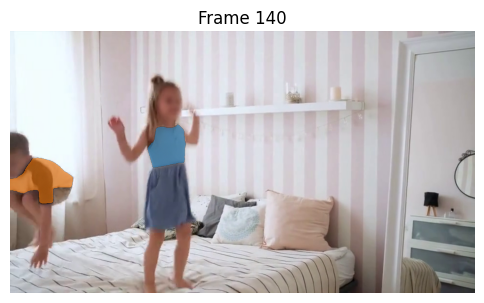

Propagating in video:  80%|███████▉  | 159/199 [01:18<00:19,  2.08it/s, stored_cond_mem=2, stored_non_cond_mem=320]

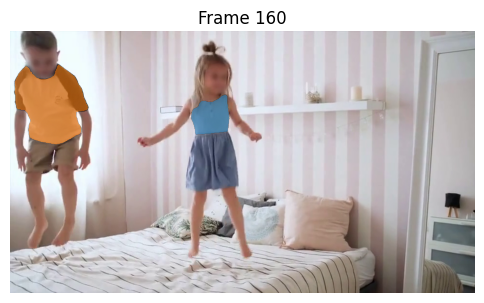

Propagating in video:  90%|████████▉ | 179/199 [01:28<00:09,  2.08it/s, stored_cond_mem=2, stored_non_cond_mem=360]

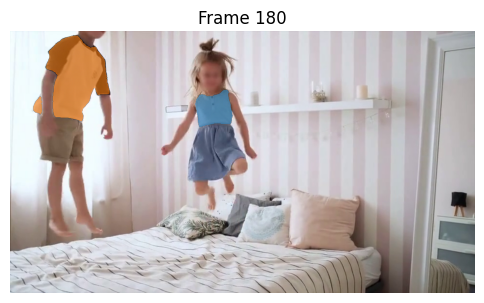

Propagating in video: 100%|██████████| 199/199 [01:38<00:00,  2.02it/s, stored_cond_mem=2, stored_non_cond_mem=398]


In [11]:
pbar = tqdm(range(1, n_frames), desc="Propagating in video")

for f in pbar:
    frame = read_frame(cap)

    if frame is None:
        break

    results = predictor.forward(frame=frame, frame_idx=f)

    n_cond_mem_obj0 = predictor.memory_bank.count_stored_conditional_memories(obj_id=0)
    n_non_cond_mem_obj0 = predictor.memory_bank.count_stored_non_conditional_memories(obj_id=0)
    n_cond_mem_obj1 = predictor.memory_bank.count_stored_conditional_memories(obj_id=1)
    n_non_cond_mem_obj1 = predictor.memory_bank.count_stored_non_conditional_memories(obj_id=1)

    n_non_cond_mem_total = n_non_cond_mem_obj0 + n_non_cond_mem_obj1
    n_cond_mem_total = n_cond_mem_obj0 + n_cond_mem_obj1

    pbar.set_postfix({
        "stored_cond_mem": n_cond_mem_total,
        "stored_non_cond_mem": n_non_cond_mem_total
    })

    if f % 20 == 0:
        plt.figure(figsize=(6, 4))
        plt.title(f"Frame {f}")
        plt.axis("off")
        plt.imshow(frame.permute(1, 2, 0).cpu().numpy())
        show_mask((results[0].best_mask_logits > 0), plt.gca(), obj_id=0)
        show_mask((results[1].best_mask_logits > 0), plt.gca(), obj_id=1)
        plt.show()

pbar.close()

cap.release()
cv2.destroyAllWindows()